# COMP 551 — Assignment 4

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [37]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import unicodedata

import os
import pickle # to save models

Plot defaults

In [3]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
MODELDIR = './models/'
os.makedirs(SAVEDIR, exist_ok=True)
os.makedirs(MODELDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Dataset

## Get data

X is input data that include text sequences

Y is target value 

YL1 is target value of level one (parent label) --> scientific field {0-6}

YL2 is target value of level one (child label) --> subfield {0-32}

Labels in YL1 (scientific field):

- 0 - Computer Science
- 1 - Electrical Engineering
- 2 - Psychology
- 3 - Mechanical Engineering
- 4 - Civil Engineering
- 5 - Medical Science
- 6 - Biochemistry


In [39]:
def load_data(file_path, dtype=str)->np.ndarray:
    # read file 
    with open(file_path, "r") as f:
        lines = [line.strip() for line in f]  # list of all lines

    if dtype == int:
        return [int(x) for x in lines]  # make sure target lists are int type
    
    return np.array(lines)  # return array


def clean_text(text):
    text = text.lower()  # lowercase

    text = unicodedata.normalize("NFKD", text) # droping accents
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")

    punctuation = ",.;:!?(){}[]\"'*/\\" # removing punctuation
    for p in punctuation:
        text = text.replace(p, " ")

    cleaned = []
    for ch in text:
        if ch.isalnum() or ch == '-' or ch == ' ': # keeping only alphanumeric, hyphens and spaces
            cleaned.append(ch)
        else:
            cleaned.append(" ")
    text = "".join(cleaned)

    while "  " in text:
        text = text.replace("  ", " ") # remove double spaces
    
    return text.strip()


class WOSDataset(Dataset):
    # class to build a torch dataset from some txt files
    # IF WE DO TRAIN/TEST SPLIT ADD IT IN HERE AND RETURN TRAIN DATASTE & TEST DATASET SEPARATELY

    def __init__(self, dataset_dir):
        self.X = load_data(dataset_dir + 'X.txt')
        self.Y = load_data(dataset_dir + 'Y.txt', dtype=int)
        self.YL1 = load_data(dataset_dir + 'YL1.txt', dtype=int)
        self.YL2 = load_data(dataset_dir + 'YL2.txt', dtype=int)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        raw = self.X[idx]
        cleaned = clean_text(raw)
        return cleaned, self.Y[idx], self.YL1[idx], self.YL2[idx]


In [52]:
# Loading WOS11967
dataset_dir = './datasets/WOS11967/'
WOS11967_dataset = WOSDataset(dataset_dir)

# train test split
TRAIN_RATIO = 0.8
num_train = int(len(WOS11967_dataset) * TRAIN_RATIO)
num_test = len(WOS11967_dataset) - num_train
train_dataset, test_dataset = torch.utils.data.random_split(WOS11967_dataset, [num_train, num_test])

# Get dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Note: X are strings so they currently get returned as a tuple when we get a batch
# eg. sample_X = (
#     "abstract1",
#     "abstract2",
#     "abstract3",
#     ...
# )


# Check data
num_instances = len(WOS11967_dataset)
print(f'Total number of samples: {len(WOS11967_dataset)}')

num_classes_YL1 = len(set(WOS11967_dataset.YL1))
print(f'Number of classes in YL1 (parent labels): {num_classes_YL1}')

num_classes_YL2 = len(set(WOS11967_dataset.YL2))
print(f'Number of classes in YL2 (child labels): {num_classes_YL2}')


# Check a sample (one batch)
sample_X, sample_Y, sample_YL1, sample_YL2 = next(iter(train_loader))
print(len(sample_X))  # (batch_size,)  THIS IS A TUPLE OF STRINGS
print(sample_Y.shape)  # (batch_size,)

Total number of samples: 11967
Number of classes in YL1 (parent labels): 7
Number of classes in YL2 (child labels): 5
32
torch.Size([32])


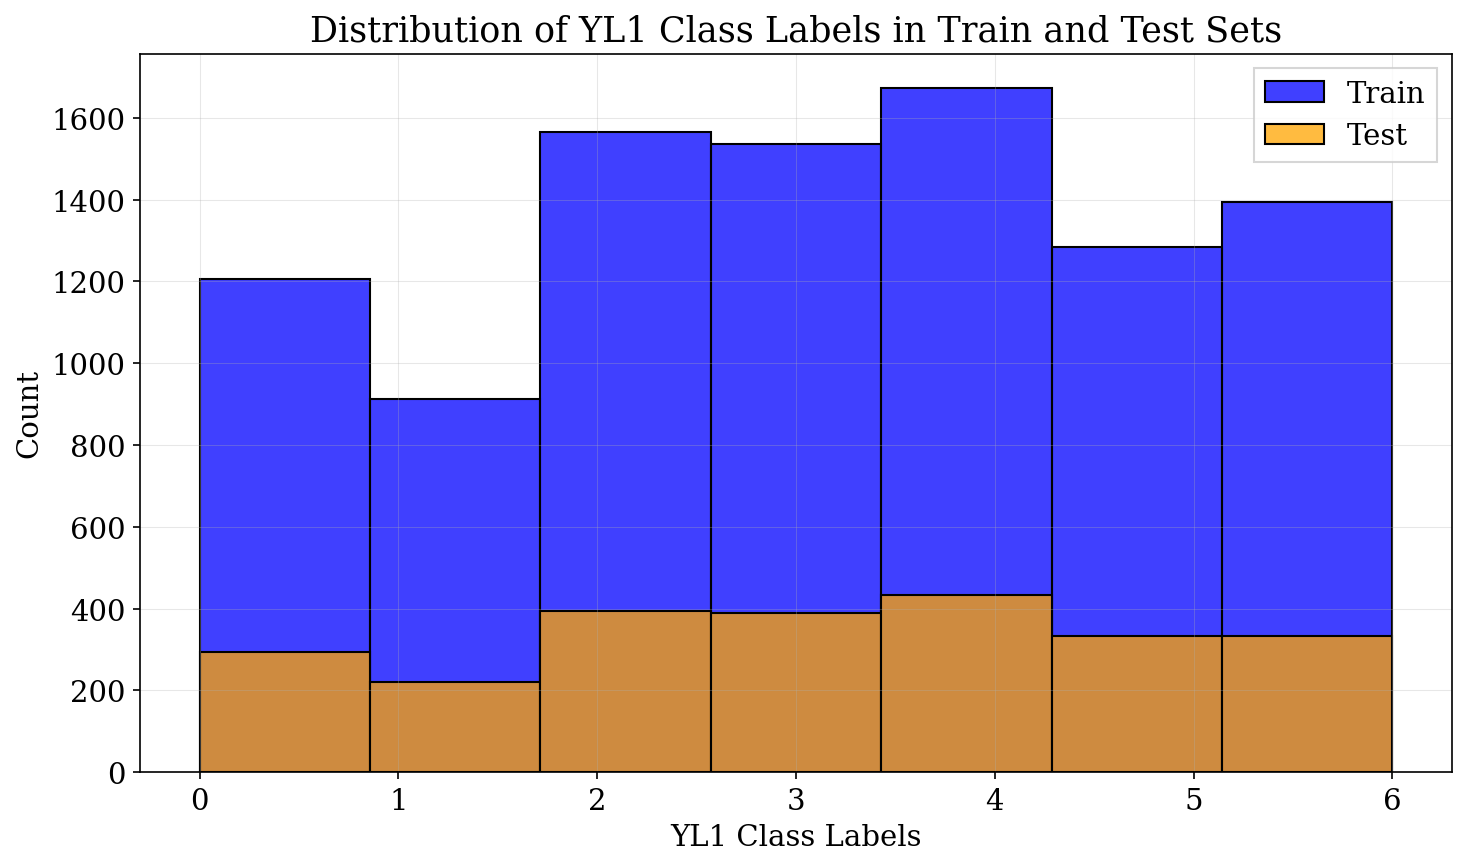

In [59]:
# plotting distribution for train and test set (for YL1)
Y_train = [train_dataset[i][2] for i in range(len(train_dataset))]
Y_test = [test_dataset[i][2] for i in range(len(test_dataset))]

sns.histplot(Y_train, bins=num_classes_YL1, kde=False, color='blue', label='Train')
sns.histplot(Y_test, bins=num_classes_YL1, kde=False, color='orange', label='Test')
plt.xlabel('YL1 Class Labels')
plt.ylabel('Count')
plt.title('Distribution of YL1 Class Labels in Train and Test Sets')
plt.legend()
plt.show()

## Preprocess data

Things to clean (done):
- special charaters (accents, non-ASCII characters, etc)
- capitalization
- Remove tabs or non-single spaced spaces
- Remove poncutation, eg: , . ; : ( ) [ ]

Things to clean (to do):
- some abstracts end in citations, eg: (C) 2016 Elsevier B.V. All rights reserved.
- some abstracts contain weblinks, eg: the Menpo Project (http://www.menpo.org)
- some have institution of origin mentioned, eg: School of Aerospace, Mechanical and Manufacturing Engineering, RMIT University
- some use periods as part of chemical/physical formulas: eg, reduce PM2.5 effects 

In [ ]:
# Pre-procesing data for LSTM


In [ ]:
# Pre-processing data for BERT

# Implement LSTM class

- can use pytorch.nn.Module
- For the LSTM model, you must design the data pre-processing pipeline that turns the unstructured text data into
numerical features. You are free to choose your encoding method, including pre-trained methods like word2vec;
however, there should be some justification for your choice in your report.

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.Wf = nn.Linear(input_size, hidden_size) # forget gate
        self.bf = nn.Parameter(torch.zeros(hidden_size)) # forget gate bias
        
        self.Wi = nn.Linear(input_size, hidden_size) # input gate
        self.bi = nn.Parameter(torch.zeros(hidden_size)) # input gate bias
        
        self.Wo = nn.Linear(input_size, hidden_size) # output gate
        self.bo = nn.Parameter(torch.zeros(hidden_size)) # output gate bias
        
        self.Wc = nn.Linear(input_size, hidden_size) # candidate state
        self.bc = nn.Parameter(torch.zeros(hidden_size)) # candidate state bias
        
        self.Wy = nn.Linear(hidden_size, output_size) # output layer
        self.by = nn.Parameter(torch.zeros(output_size)) # output layer bias
        
        
    def forward(self, x, hidden):
        i_t = nn.Sigmoid(self.Wi @ x + self.bf + self.Wh @ hidden + self.bh)
        f_t = nn.Sigmoid(self.Wf @ x + self.bf + self.)
    
    def fit(self, X, Y):  # MAKE THIS ACCEPT A TORCH DATASET SO WE CAN USE THE GPU
        pass
    
    def predict(self, X):  # SAME FOR HEREEEE!!
        pass
    
    def evaluate_acc(self, Y, Yhat):
        return np.mean(Y == Yhat)

# BERT model

- For BERT, you can use the transformers package to tokenize the input text and convert the tokens into numeri-
cal features https://pytorch.org/hub/huggingface_pytorch-transformers/
- 

# Experiments

## some experiment etc